In [1]:
import numpy
from matplotlib import pyplot
import time
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
#function of 3D plot
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot
    of the scalar field p.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction;
        default: 'z'.
    elev : float, optional
        Elevation angle in the z plane;
        default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane;
        default: 45.0.
    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    fig.add_axes(ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

In [4]:
def l2_norm(p, p_ref):
    """
    Computes and returns the relative L2-norm of the difference
    between a solution p and a reference solution p_ref.

    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats.
    p_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The relative L2-norm of the difference.
    """
    l2_diff = (numpy.sqrt(numpy.sum((p - p_ref)**2)) /
               numpy.sqrt(numpy.sum(p_ref**2)))
    return l2_diff

In [13]:
#set parameters
nx = 128
ny = 128
Lx = 5.0
Ly = 5.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

x = numpy.linspace(0.0, Lx, num = nx)
y = numpy.linspace(0.0, Ly, num = ny)
X, Y = numpy.meshgrid(x, y)
#set initial conditions
p0 = numpy.zeros((ny, nx))
p0[-1, :] = numpy.sin((1.5*numpy.pi*x) / Lx)
#print(p0)

In [6]:
import numba
from numba import jit

In [7]:
@jit(nopython=True)
def poisson_2d_sor(p0, X, Y, omega, maxiter=20000, rtol=1e-6):
    
    nx, ny = p0.shape
    p = p0.copy()
    diff = rtol + 1.0
    ite = 0
    conv = []
    b = X + numpy.sin(Y)
    while diff>rtol and ite<maxiter:
        pn = p.copy()
        
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                p[j, i] = (1 - omega)*p[j, i] + (omega/4)*(p[j-1, i] + p[j+1, i] + p[j, i-1] + p[j, i+1] + b[j, i])
        #Applying Neumann bc (zero-gradient) at right boundary
        for j in range(1, ny-1):
            p[j, -1] = 0.25*(p[j-1, -1] + p[j+1, -1] + 2.0*p[j, -2])
            
        # Compute the relative L2-norm of the difference.
        diff = numpy.sqrt(numpy.sum((p - pn)**2) / numpy.sum(pn**2))
        conv.append(diff)
        ite += 1
        
    return p, ite, conv
        
    

In [8]:
import math

In [9]:
omega_1 = 2/(1 + (math.pi/nx))
print(omega_1)

1.9520885389597442


In [10]:
tic = time.time()
p, ites, conv_sor = poisson_2d_sor(p0, X, Y, omega_1, maxiter = 20000, rtol=1e-6)
toc = time.time()

print('SOR(omega={}): {} iterations '.format(omega_1, ites) + 'to reach a relative difference of {}'.format(conv_sor[-1]))
print('time required {}'.format(toc - tic))

SOR(omega=1.9520885389597442): 789 iterations to reach a relative difference of 9.890977782377511e-07
time required 2.8872992992401123


<ipython-input-3-f0314b47ee18>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


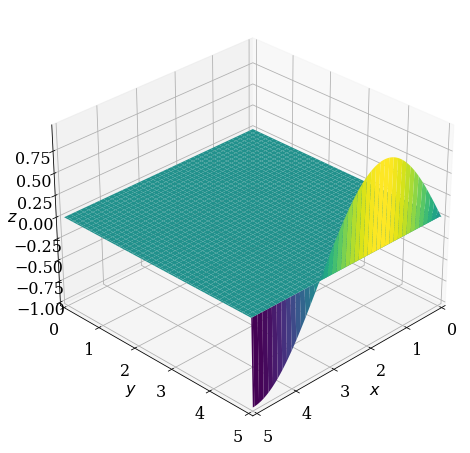

In [11]:
plot_3d(x, y, p0, label='$z$', elev=30.0, azim=45.0)

<ipython-input-3-f0314b47ee18>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


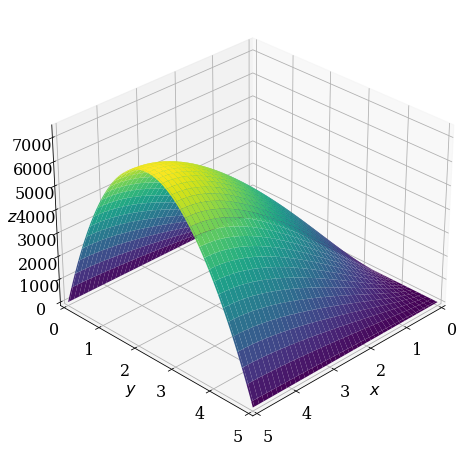

In [12]:
plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0)